In [1]:
!pip install --quiet snntorch tonic

In [3]:
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import time
import os
import h5py
import numpy as np
from tonic.dataset import Dataset

def to_frames(events):
    frame_transform = tonic.transforms.ToFrame(
        sensor_size= (128, 128, 2),
        n_time_bins=100)
    return frame_transform(events)

In [4]:
class NFDD(Dataset):
    def __init__(self, data_dir, save_to, transform=None):
        super().__init__(save_to)
        self.data_dir = data_dir
        self.data = []
        self.targets = []
        self.transform = transform

        self.class_map = {
            "Walk": 0,
            "Sit": 1,
            "Fall": 2
        }

        self.sensor_size = (128, 128, 2)
        self.dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)])
        self.load_data()

    def load_data(self):
        for folder_name in os.listdir(self.data_dir):
            folder_path = os.path.join(self.data_dir, folder_name)
            if os.path.isdir(folder_path) and folder_name in self.class_map:
                label_idx = self.class_map[folder_name]
                for file_name in sorted(os.listdir(folder_path)):
                    file_path = os.path.join(folder_path, file_name)
                    if file_name.endswith('.h5'):
                        event_data = self.load_h5_file(file_path)
                        self.data.append(event_data)
                        self.targets.append(label_idx)

    def load_h5_file(self, file_path):
        with h5py.File(file_path, 'r') as h5_file:
            events = np.array(h5_file['events'])
            x = events[:, 1].astype(np.int16)
            y = events[:, 2].astype(np.int16)
            polarity = events[:, 3].astype(bool)
            time = events[:, 0].astype(np.int64) / 10000  # Convert to microseconds
            structured_data = np.zeros(events.shape[0], dtype=self.dtype)
            structured_data['x'] = x
            structured_data['y'] = y
            structured_data['p'] = polarity
            structured_data['t'] = time
            return structured_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        events, label = self.data[idx], self.targets[idx]
        if self.transform:
            events = self.transform(events)
        return events, label

In [5]:
data_dir = '/kaggle/input/neuromorphic-falling-detection-dataset/NFDD'
dataset = NFDD(data_dir, save_to=data_dir)  # Cambia esto a la ruta deseada para guardar

In [6]:
from sklearn.model_selection import train_test_split

all_events = dataset.data
all_labels = dataset.targets

# Convertir a arrays de NumPy si no lo son
all_events = np.array(all_events, dtype=object)  # dtype=object para mantener arrays de diferentes tamaños
all_labels = np.array(all_labels)

# Divide en 60% para entrenamiento y 40% para prueba, pero utilizaremos solo 10% del total para prueba
train_events, temp_test_events, train_labels, temp_test_labels = train_test_split(
    all_events,
    all_labels,
    test_size=0.4,  # 40% para prueba temporal
    random_state=42,
    stratify=all_labels
)

# Divide el 40% restante para obtener solo el 10% del total como prueba
test_events, _unused_events, test_labels, _unused_labels = train_test_split(
    temp_test_events,
    temp_test_labels,
    test_size=0.25,  # 25% del 40% equivale al 10% del total
    random_state=42,
    stratify=temp_test_labels
)

print("Número de eventos de entrenamiento:", len(train_events))
print("Número de eventos de test:", len(test_events))

Número de eventos de entrenamiento: 720
Número de eventos de test: 360


In [7]:
w,h=128, 128
n_frames=60 #100

debug = False

transforms = tonic.transforms.Compose([
    #tonic.transforms.Denoise(filter_time=100), # removes outlier events with inactive surrounding pixels for 10ms
    #tonic.transforms.Downsample(sensor_size=(128, 128, 2), target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])

# Crear datasets de entrenamiento y validación
class NFDDSubset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        events = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            events = self.transform(events)
        return events, label

train_dataset = NFDDSubset(train_events, train_labels, transform=transforms)  # Aplicar transformaciones si es necesario
test_dataset = NFDDSubset(test_events, test_labels, transform=transforms)

In [8]:
from torch.utils.data import DataLoader
#
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


cached_train = tonic.DiskCachedDataset(train_dataset, cache_path='/temp/nfdd/train')
cached_test = tonic.DiskCachedDataset(test_dataset, cache_path='/temp/nfdd/test')

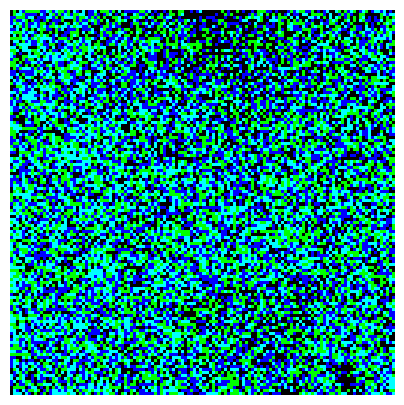

In [9]:
frames, label = train_dataset[6]
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")

GPUs Available: 2


In [11]:
grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
beta = 0.5

# 12C5-MP2-32C5-MP2-800FC11 https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_7.html
net = nn.Sequential(
    nn.Conv2d(2, 12, 5), 
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(26912, 11),  # Cambiar 800 por 26912
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

loss_hist = []
acc_hist = []
test_acc_hist = []

In [12]:
def validate_model():
    correct, total = 0, 0  
    for batch, (data, targets) in enumerate(iter(test_loader)): 
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch] 
        spk_rec = forward_pass(net, data)         
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

In [14]:
train_loader = torch.utils.data.DataLoader(cached_train, batch_size=16, shuffle=True, drop_last=True, 
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_test, batch_size=6, shuffle=False, drop_last=True, 
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

In [15]:
start_time = time.time()
best_acc = 0.0
num_epochs = 20
cnt = 0

for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        data = data.float()
        targets = targets.to(device)
        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        if cnt % 50 == 0:
            print(f"Epoch {epoch}, Iteration {batch} \nTrain Loss: {loss.item():.2f}")
            print(f"Train Accuracy: {SF.accuracy_rate(spk_rec, targets) * 100:.2f}%")
            test_acc = validate_model()
            test_acc_hist.append(test_acc)
            print(f"Test Accuracy: {test_acc * 100:.2f}%\n")
            
            # Save the model if the validation accuracy improves
            if test_acc > best_acc:
                print(f"New best model found! Saving model at epoch {epoch} with accuracy {test_acc * 100:.2f}%")
                best_acc = test_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                    'loss': loss.item(),
                }, "best_model.pth")

        cnt+=1

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Epoch 0, Iteration 0 
Train Loss: 5.67
Train Accuracy: 31.25%
Test Accuracy: 22.50%

New best model found! Saving model at epoch 0 with accuracy 22.50%
Epoch 1, Iteration 5 
Train Loss: 1.28
Train Accuracy: 93.75%
Test Accuracy: 98.06%

New best model found! Saving model at epoch 1 with accuracy 98.06%
Epoch 2, Iteration 10 
Train Loss: 0.53
Train Accuracy: 100.00%
Test Accuracy: 98.61%

New best model found! Saving model at epoch 2 with accuracy 98.61%
Epoch 3, Iteration 15 
Train Loss: 0.68
Train Accuracy: 100.00%
Test Accuracy: 98.61%

Epoch 4, Iteration 20 
Train Loss: 0.49
Train Accuracy: 100.00%
Test Accuracy: 99.44%

New best model found! Saving model at epoch 4 with accuracy 99.44%
Epoch 5, Iteration 25 
Train Loss: 0.42
Train Accuracy: 100.00%
Test Accuracy: 99.44%

Epoch 6, Iteration 30 
Train Loss: 0.25
Train Accuracy: 100.00%
Test Accuracy: 99.44%

Epoch 7, Iteration 35 
Train Loss: 0.18
Train Accuracy: 100.00%
Test Accuracy: 99.72%

New best model found! Saving model at ep

KeyboardInterrupt: 

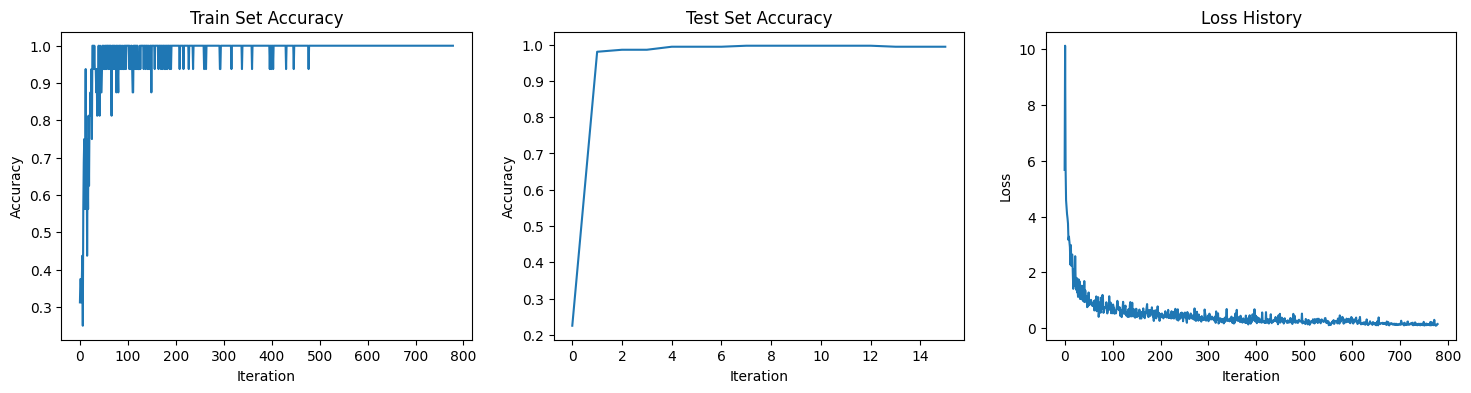

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")

plt.show()

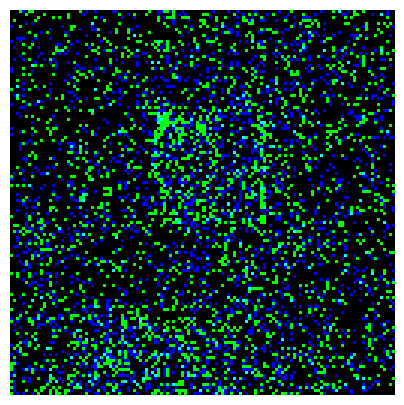

Valor predicho: 1, Etiqueta correcta: 1


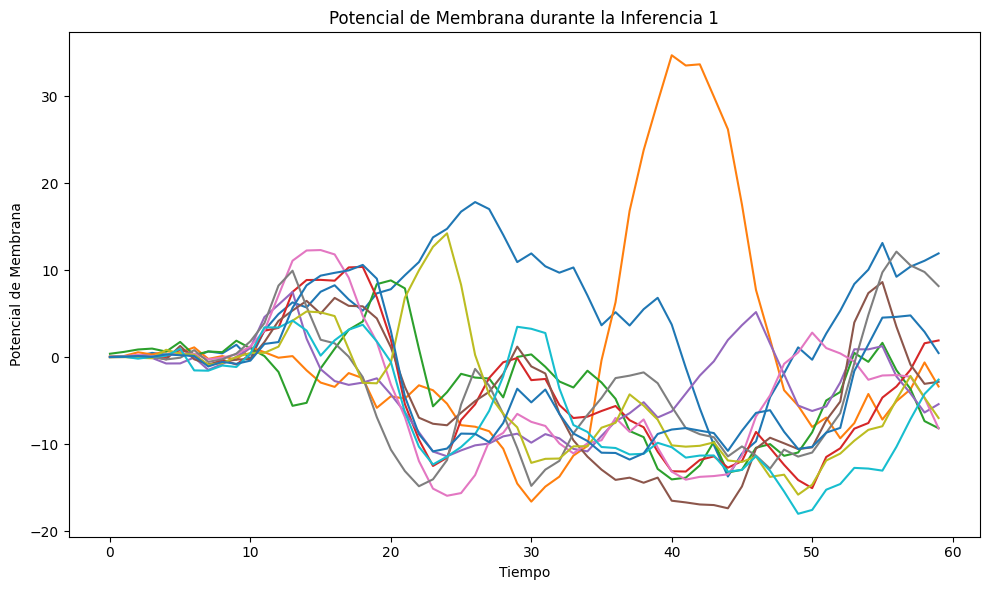

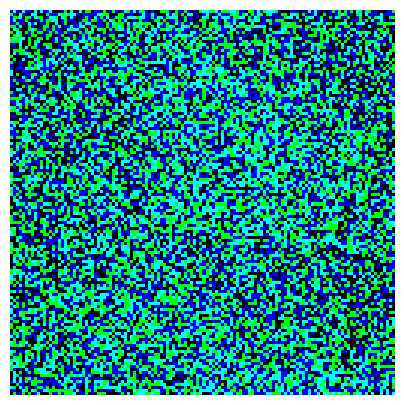

Valor predicho: 3, Etiqueta correcta: 3


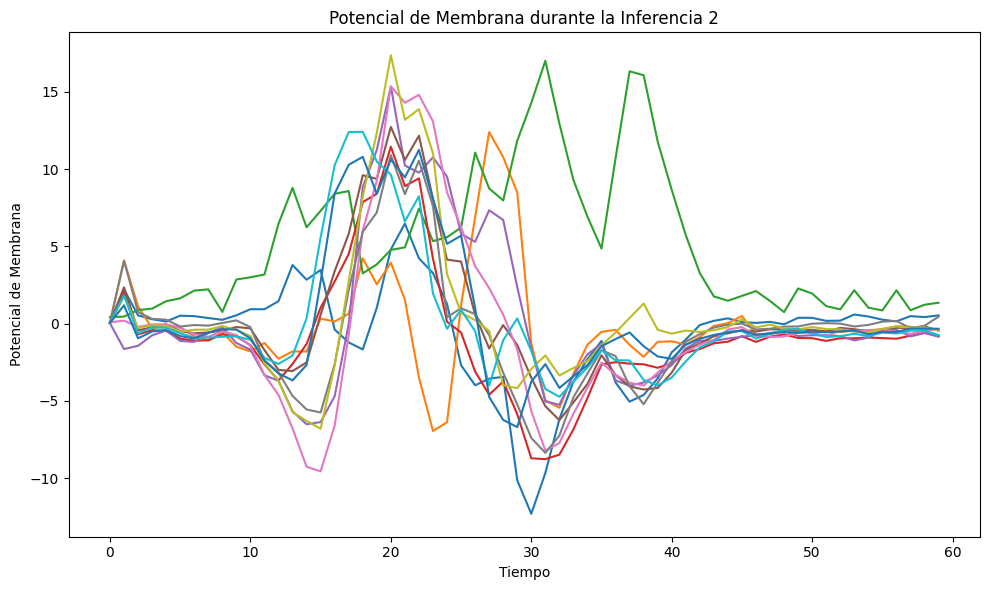

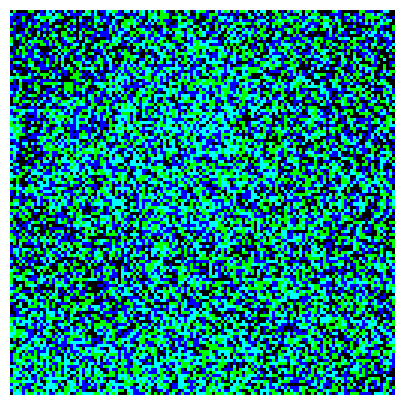

Valor predicho: 3, Etiqueta correcta: 3


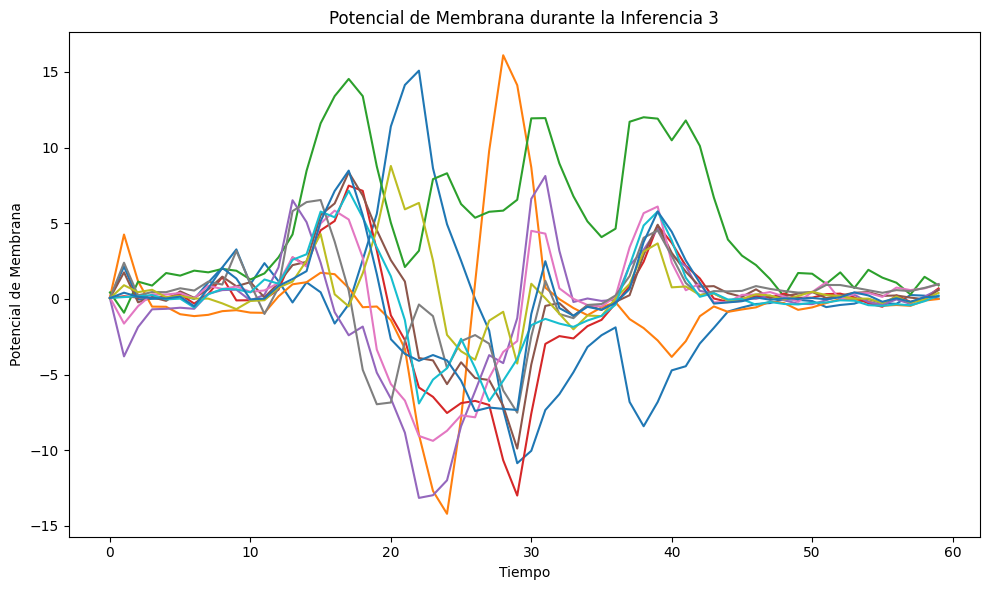

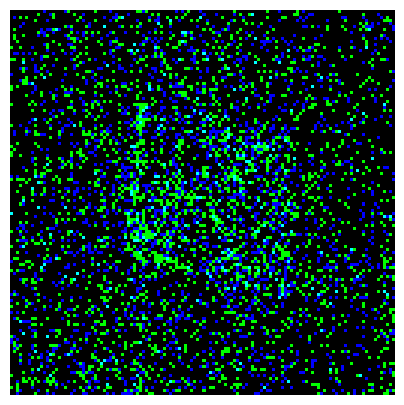

Valor predicho: 1, Etiqueta correcta: 1


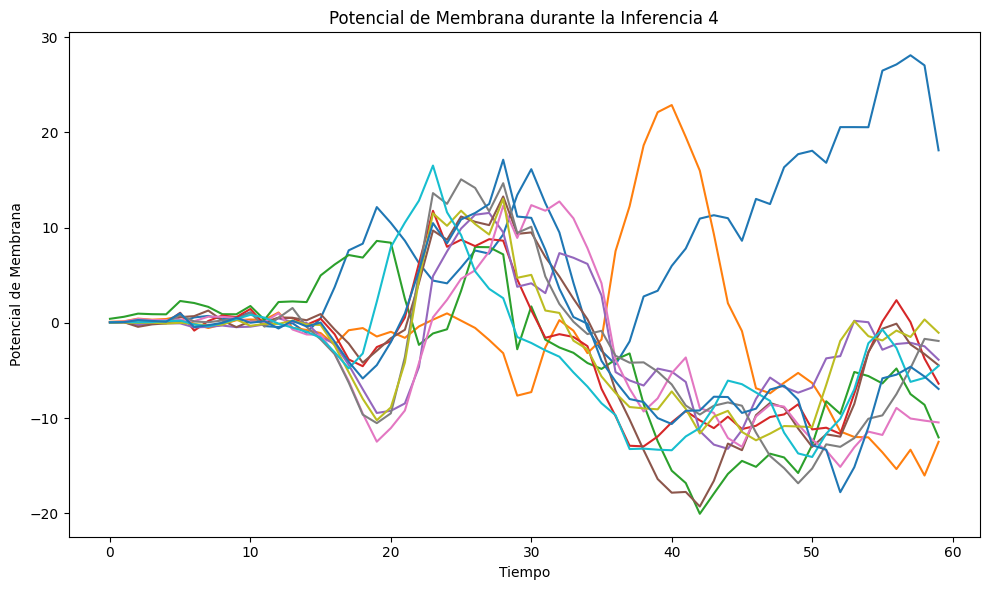

Predicción: 1, Etiqueta correcta: 1
Predicción: 3, Etiqueta correcta: 3
Predicción: 3, Etiqueta correcta: 3
Predicción: 1, Etiqueta correcta: 1


In [33]:
import torch
import matplotlib.pyplot as plt
import snntorch as snn
from IPython.display import HTML, display

def forward_pass2(net, data):
    spk_rec = []
    mem_rec = []  # Lista para registrar el potencial de membrana en cada paso
    snn.utils.reset(net)  # Resetea los estados internos de las neuronas (importante para secuencias)
    
    for step in range(data.size(0)):  # data.size(0) es el número de pasos temporales
        spk_out, mem_out = net(data[step])  # Obtener los spikes y el potencial de membrana
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)  # Almacenar el potencial de membrana
    
    return torch.stack(spk_rec), torch.stack(mem_rec)

# Obtener un DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(cached_test, batch_size=1, shuffle=True, drop_last=True,
                                          collate_fn=tonic.collation.PadTensors(batch_first=False),)

# Lista para almacenar las predicciones y etiquetas correctas
predictions = []
true_labels = []

for i in range(4):  # Realizar 4 inferencias aleatorias
    data, target = next(iter(test_loader))
    data = data.to(device)
    target = target.to(device)
    
    # Suponiendo que data tiene la forma (num_frames, height, width, channels)
    frames = data[:, 0, ...].cpu()
    ani = tonic.utils.plot_animation(frames)
    display(HTML(ani.to_jshtml()))

    # Realizar la inferencia
    spk_rec, mem_rec = forward_pass2(net, data)
    
    # Obtener la etiqueta predicha
    predicted_label = torch.argmax(spk_rec.sum(dim=0), dim=1).item()
    
    # Almacenar la predicción y la etiqueta correcta
    predictions.append(predicted_label)
    true_labels.append(target.item())
    
    print(f"Valor predicho: {predicted_label + 1}, Etiqueta correcta: {target.item() + 1}")

    # Crear un subplot para el potencial de membrana
    plt.figure(figsize=(10, 6))

    # Graficar el potencial de membrana (mem_rec)
    neuron_count = mem_rec.size(1)  # Número de neuronas
    for neuron in range(neuron_count):  # Iterar sobre las neuronas
        plt.plot(mem_rec[:, neuron].detach().cpu().numpy())  # Graficar cada neurona sin leyenda

    plt.title(f"Potencial de Membrana durante la Inferencia {i + 1}")
    plt.xlabel("Tiempo")
    plt.ylabel("Potencial de Membrana")
    plt.tight_layout()
    plt.show()

# Imprimir los resultados finales
for pred, true in zip(predictions, true_labels):
    print(f"Predicción: {pred + 1}, Etiqueta correcta: {true + 1}")